In [84]:
# Display the Readme file as a notebook header:
import IPython
with open("README.md") as f:
    display(IPython.display.Markdown(f.read()))

# mcmc-talk

Hello! This repository houses the materials for a presentation given to the [Murray Lab](https://medicine.yale.edu/lab/murray/) on using Markov Chain Monte Carlo for fitting statistical models.

The slides are in the format of a Jupyter notebook written to be presentation-friendly. It can be found at `./mcmc-talk.ipynb` and may be updated from time to time. You are highly encouraged to follow along and experiment by running and modifying the Python code for yourself. The only required library is `bambi==0.7.1` (homepage [here](https://bambinos.github.io/bambi/)); many other relevant libraries (`numpy`, `pandas`, `matplotlib`, `pymc3`, etc.) are pulled in as dependences.

A few supporting images were pulled from the internet or various texts. Wherever used in the notebook, attribution is given adjacent to the embedded images.

Please feel free to reach out to me with questions/follow-ups, or to access a recording of the original presentation!

*Continue on down the notebook for more...*


# Intro to MCMC (*Markov Chain Monte Carlo*) for Model Fitting

### Cove Geary

### Last Updated May 4, 2022

## Motivating Problem: PyDDM

![](img/pyddm.png)

Before diving headfirst into the land of Bayesian models, Markov Chains, and MCMC, here's an example of a motivating problem.

Our lab has developed a great package for fitting *Generalized Drift Diffusion Models* or GDDMs, `PyDDM` ([homepage](https://pyddm.readthedocs.io/en/stable/), [paper](https://elifesciences.org/articles/56938)). A GDDM is a flexible method for modeling response times in two-alternative forced-choice tasks. In a simple DDM, fittable parameters may include:

* Starting point of the decision particle
* Drift rate of the particle
* Noisiness of the drift process
* The width between the upper and lower bounds
* Non-decision time (e.g. to account for other non-decision-related processing)

In a GDDM, these parameters are much more complex, and there is usually no analytical solution. In order to fit a GDDM to data, `PyDDM` solves the Fokker-Plank equation via some fancy numerical methods and performs maximum likelihood estimation (MLE). What we get is a point estimate of the most likely model parameters given an observed dataset of reaction times.

* PyDDM returns a **maximum likelihood** estimate of the optimal model parameters, given some dataset of RTs. This is a **point estimate**.
* *What is a point estimate?*

Consider the two proability distributions below. Suppose that they are each likelihood distributions for a two-parameter model, given two different datasets. Consider: what is the MLE for each distribution?

($x$ and $y$ axes represent each of the model parameters, while the $z$-axis represents probability density.)

![](img/gaussians-2d.png)

Answer: in both cases it is the parameter vector $(0, 0)$, because both distributions have the most probability density ("maximum likelihood") at $(0, 0)$.

What pros and cons can you imagine to estimating model parameters in this way? (...Should we be as confident with the MLE in the right-side example as we are in the left-side example?)

### Drawbacks to using MLE to fit GDDM models:

1. We do not have any measure of uncertainty in parameter estimates.

    * Necessary for hypothesis testing/inference on parameters!
    * In other classical models that calculate a MLE point estimate (e.g. linear regression), it is possible to derive the *significance* of each model parameter so long as the modeling assumptions hold (e.g. standard error, t-statistic for linear regression).
    * This is not always possible with an arbitrary statistical model.

2. We cannot model differences in parameter values for different subjects or groups (in the same model).

    * Necessary for modeling differences in the data factors/levels! (Group or subject-level effects)
    * E.g.: treatment vs. control; or subject-specific parameters.

1. We do not have any measure of uncertainty in parameter estimates.
2. We cannot model differences in parameter values for different subjects or groups.

### A Bayesian, sampling-based solution:

$\rightarrow$ We can use MCMC to calculate the **full distribution** of optimal model parameters. (More formally: we can draw many samples from the posterior distribution of a complex model, given some dataset to fit.)

Bonus content: specifying our model in this way allows us to specify **arbitrary hierarchy** among model parameters. Groub/subject-level effects come free with a Bayesian model! This will allow us to make the most of our data by leveraging the structure that exists within it.

Let's move on to developing the necessary foundations that lead to MCMC for model fitting.

## Primer: Model-Fitting

Essentially everyone in this lab is fitting statistical models of some kind; hopefully this idea should not be too foreign to you. But the processes or algorithms are sometimes abstracted so far away from what we need to do to use a model that we may lose sight of the basics.

Poll for the room: what model-fitting methods can you name? (What have you used, heard of..., ?)

Your answers:
* MLE (maximum likelihood)
* Photoshop (ha)
* MAP (maximum a posteriori)
* MSE (mean squared error loss function)
* Gaussian Processes

### Simple Examples

![](img/modelfitting.png)

A couple of more "classical" examples that may be familiar. Top: MLE (this is equivalent to OLS for normal linear regression). Bottom: gradient descent.

Images from:

* https://www.probabilitycourse.com/chapter8/8_2_3_max_likelihood_estimation.php
* https://en.wikipedia.org/wiki/Gradient_descent#/media/File:Gradient_descent.svg

As discussed, classical statistical approaches generally provide **point estimates** for the parameters. Mainly what we care about in these approaches is the point value that the method "converges to."

How can we calcuate the **distribution** of model parameters that fit the data?

* If we can sample repeatedly *from that distribution*, then those samples would represent an *empirical posterior distribution*.
* MCMC provides a way to sample from the posterior. "Convergence" is guaranteed by the use of a special **Markov chain**.

## Primer: Markov Chains

A Markov chain is a sequence of random variables $X_0, X_1, \dots$, where $X_t$ represents the state of the system at time $t$. The transition $X_t \to X_{t+1}$ is given by a probability transition matrix.

The formal definition of a Markov chain is more specific than this. One will need to specify, for example, the "state space" (the set of all possible states), the initial condition/distribution of the beginning of the chain, and, crucially, the properties of that transition matrix. But for our purposes, this will be plenty to understand the role of Markov chains in MCMC.

To operationalize this concept, consider the following simple example:

![](img/markov-frog.png)

This example and image are given by the manuscript "Probability, Statistics, and Data Analysis:
A Bayesian Introductory Course" by Joe Chang, June 6 2019.

The diagram on the left expresses a Markov chain for a frog that leaps from lily pad to lily pad. If we think of each lily pad as a "state", then the state space is $S=\{1,2,3\}$. The directed edges between lily pads represent the probability of the frog jumping from one lily pad to another at each transition time.

We can also succinctly represent this process with the transition matrix $P$ as shown on the right: each entry $P_{ij}$ gives the probability of jumping from lily pad $i$ to $j$.

Something nice about Markov chains is that they are easy to simulate. We could code up a virtual frog in only a few lines of code, as all that we need to know are the transition probabilities and the starting conditions! It helps that these days, computers are quite good at running `for` loops very quickly.

The deep froggy question:

* *How likely is it, in the long run, that the frog is on lily pad $i$ at any given time?*

Can be equivalently rephrased:

* *What is the limiting distribution of $X_t$?*

This is often called the **stationary distribution** of the Markov chain. In this case, one may derive an algebraic solution. However, if a stationary distribution exists, we can always approximate it to some arbitrary level of precision by simulating many transitions of the chain!

*So!* If a transition function can be crafted which has the model's posterior as its stationary distribution, then we can estimate the posterior simply by simulating a chain with this transition.

Keep this insight in mind for later.

For a hint on how this fancy transition function can come about without knowing the posterior distribution, we must turn to **Bayes' Rule**. Note that you don't need to memorize this math in order to use MCMC, but it is helpful to keep in mind. Furthermore, I would be absolutely remiss if I gave a talk on Bayesian model-fitting and never mentioned Bayes' Rule.

### Obligatory Bayes' Rule

It turns out that we can craft such a transition function without needing to know the posterior distribution.

We only need:

* $P(\theta)$: the model's **prior probability**
* $P(D|\theta)$: the model's **likelihood**

(where $\theta$ is the model parameter vector and $D$ represents the dataset).

Behind the scenes of MCMC, this is due to **Bayes' Rule**:

$$P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)} \propto P(D|\theta)P(\theta)$$

More simply: **Posterior** $\propto$ **likelihood** $\times$ **prior**.

### Markov Chain Takeaways

* Simulating many steps of the chain will produce an empirical distribution that gives the probability of being in each state.
    * "Memoryless": each transition depends only on the current state, not the history of past states.
    * $\implies$ a simulated Markov chain is **not** a set of independently distributed samples. There will be some autocorrelation.
* In MCMC for model fitting:
    * "State" is any valid combination of model parameters. (The state space will likely be continuous and multidimensional.)
    * We will want to craft a transition function that has the posterior as its stationary distribution.
    * Bayes' Rule will help us out. However, we must set priors on our model parameters.

## Primer: Probabilistic Graphical Models ("Bayesian Networks")

The final piece of the puzzle is how to specify a model in a way that will allow us to run MCMC. As alluded to in our discussion of Bayes' Rule, the two things that we'll need to define are the **prior** $P(\theta)$ and the **likelihood** $P(D|\theta)$.

But what if we have many individual parameters within the vector $\theta$, and we'd like to place different priors on each of them? Perhaps we also want to express hierarchical or conditional relationships between these parameters. **Bayesian networks** (a specific form of probabilistic graphical models) provide an easy way to express models in this way.

In a Bayesian network, each parameter (or hyperparameter) is expressed as a node in a directed graph. In general, each node represents a random variable: prior, likelihood, data, etc. The idea behind this graph is that parent nodes (those with no child nodes) represent independent distributions. Child nodes take their parent node(s) as parameter value(s), hence child nodes represent distributions conditioned on the parent(s). See [Horný 2015](https://www.bu.edu/sph/files/2014/05/bayesian-networks-final.pdf) for a brief but more theoretical introduction.

Given this background, let's consider a couple examples of regression models expressed in this graphical specification.

Each diagram represents a model designed to perform simple linear regression. In both, the variable $y$ represents the observed/modeled data:

![](img/pgm.png)

Notice the differing use of priors and likelihood.

The left diagram was generated by `pymc`.

The right diagram is captioned: Figure 17.2: A model of dependencies for robust linear regression. The datum, yi at the bottom of the diagram, is distributed around the central tendency μi, which is a linear function of xi. Compare with Figure 16.11 on p. 437. Copyright © Kruschke, J. K. (2014). Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. 2nd Edition. Academic Press / Elsevier.

Can you identify: the **intercept** term? The **slope** term? The priors that are set on each?

A: In the left model, the intercept is the top-rightmost node $\text{Intercept}$, and the slope is $x$. In the right, the the intercept is named $\beta_0$ and the slope $\beta_1$. All of these variables are given Normal distributions as their priors. The right diagram diagram is more verbose, as it shows us the names of the distribution parameters and specifically how child nodes depend on the parents.

Can you identify: the **likelihood**? How is it distributed?

A: In general, all of our Bayesian networks will have the likelihood as the final child node that depends, whether directly or indirectly, upon all of the other nodes. Hence the likelihood node is the bottom node in each model diagram.

A further hint as to which node is the likelihood node: recall that the likelihood is defined as $P(D|\theta)$. Therefore, because the bottom node expresses how the observed data (outcome $y$ in the regression problem) is distributed (according to a Normal or a Student-T distribution, respectively), and it is conditional upon all the model parameters by nature of being the "last" child node, it must be the likelihood.

### Bayesian Networks Takeaways:

* Are directed acyclic graphs, such that:
* Each node is a random variable (it expresses a distribution).
    * Nodes can represent model parameters/hyperparameters (e.g. $\beta_0$, $\upsilon$, $\sigma$, or $\text{Intercept}$), some deterministic function of the model parameters (e.g. $\beta_0$+$\beta_1 x_i$, or $\upsilon' + 1$), and model likelihood (e.g. $y \sim P(D|\theta)$).
    * A child node is conditioned (in the probablistic sense) on its parent node(s).
* Can be used to represent any parametric statistical model, but we **must** set priors over the parameters.
* *MCMC will sample the posterior distribution of a graphical model.*

Other niceties:
* Make it very easy to express any arbitrary hierarchy or relationships between model parameters.
* Express a *generative model*: if we can sample from each node of the graph, we can sample from the likelihood, which generates samples of $y$.
* We can include nuisance parameters in our model but marginalize them out later.

Hopefully the ideas behind Bayesian networks are sitting easy with you. The graphical model framework is immensely flexible, and it can be leveraged to Bayes-ify many classical models that you may be familiar with.

* For more examples of how to translate various statistical models into Bayesian networks, consider browsing the [Examples page](https://docs.pymc.io/projects/examples/en/latest/blog.html) of the `pymc` library. `pymc` is a general-purpose Python library for building Bayesian models; it allows you to express Bayesian models in an intuitive object-oriented way.
* For a simple example, [this notebook](https://docs.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html) walks through building simple linear models, culminating in a Bayesian "mixed model."
* For an advanced example, [this notebook](https://docs.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html) gives the example of building a **Bayesian neural network**. The possibilities are far and wide.

*Payoff moment*: Given the foundations that we've built, we can now (finally) express the essence of MCMC in concise terms!

## MCMC in a nutshell

> Given a **graphical model**, MCMC is a class of algorithms that provide a **Markov transition function** designed to have a **stationary distribution** equivalent (or proportional) to that model's **posterior distribution**.

What does this mean for us?

> All that we must do is express our model as a Bayesian network, defining priors and the likelihood. The MCMC algorithm gives us the transition function. Then "model fitting" is as simple as simulating the Markov chain for many steps.

When we combine that sequence of samples from the Markov chain into a histogram, what we get is an **empirical joint posterior distribution** over the model's parameters. It's our estimate of the *distribution of best-fitting parameters*!

There are many different algorithms for MCMC. The primary difference: how that transition is calculated.

* Gibbs Sampler
* Metropolis-Hastings
* Slice Sampler
* Hamiltonian Monte Carlo
* Particle/ensemble-based

This remains an active area of research.

These are often referred to as simply the "sampler" or the "step" method.

* Statistical Machine Learning, by Han Liu and Larry Wasserman, c 2014. https://www.stat.cmu.edu/~larry/=sml/Bayes.pdf
* Slice: Neal
* HMC: Stan
* Ensemble: emcee

Description of the Metropolis-Hastings algorithm (not shown unless we would like to dive into it):

Suppose $X_t=X$ and we wish to generate a step for $X_{t+1}$. Proceed as follows:
![](img/m-h.png)

## Putting it all together

Your workflow in model-fitting with MCMC should look something like the following:

1. Define your graphical model. (Set priors and likelihood.)
2. Sanity-check your priors. (Prior predictive check.)
3. Run MCMC. (Some refer to this simply as the "inference button.")
4. Investigate the posterior:

    * Assess MCMC convergence. ($\widehat R$, trace plots, ESS, etc.)
    * Sanity-check the posterior distribution. (Posterior predictive check.)
    
5. Profit! (Use the posterior to make inferences about your data.)

## Worked Example:

### Linear Regression with MCMC

Feel free to skip ahead past these first few blocks of code...

In [17]:
%%html
<!-- For hiding code cells in a presentation but still displaying output; from https://github.com/damianavila/RISE/issues/32 -->
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

In [18]:
# https://github.com/damianavila/RISE/issues/32
def hide_code_slideshow():
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [19]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams.update({"figure.autolayout": True, "figure.dpi": 300})
SEED = 7355608

In [4]:
data = bmb.load_data("sleepstudy")
fake_data = pd.DataFrame([
    {"Reaction": 286, "Subject": -1, "Days": 0},
    {"Reaction": 288, "Subject": -1, "Days": 1},
    {"Reaction": 245, "Subject": -2, "Days": 0}])
data = pd.concat([data, fake_data])
data.Subject = data.Subject.factorize()[0] + 1
data.Subject = pd.Categorical(data.Subject)

def plot_data(data):
    assert len(pd.unique(data["Subject"])) == 20
    fig, axes = plt.subplots(4, 5, figsize=(16, 14), sharey=True, sharex=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)
    axes_flat = axes.ravel()
    for ax, subject in zip(axes_flat, data["Subject"].unique()):
        subset = data.query("Subject == @subject")
        ax.scatter(subset["Days"], subset["Reaction"], color="C0", ec="black", alpha=0.7)
        ax.set_title(f"Subject: {subject}", fontsize=14)
    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")
    return axes

We'll be using Bambi, which sets the priors for us.

This notebook is adapted from the "Sleepstudy" case study notebook in the Bambi documentation: https://bambinos.github.io/bambi/main/notebooks/sleepstudy.html

Also see https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/

Reaction time, cognitive tasks, 3 hours of sleep per night

### Our dataset

/tmp/ipykernel_82484/3618043961.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


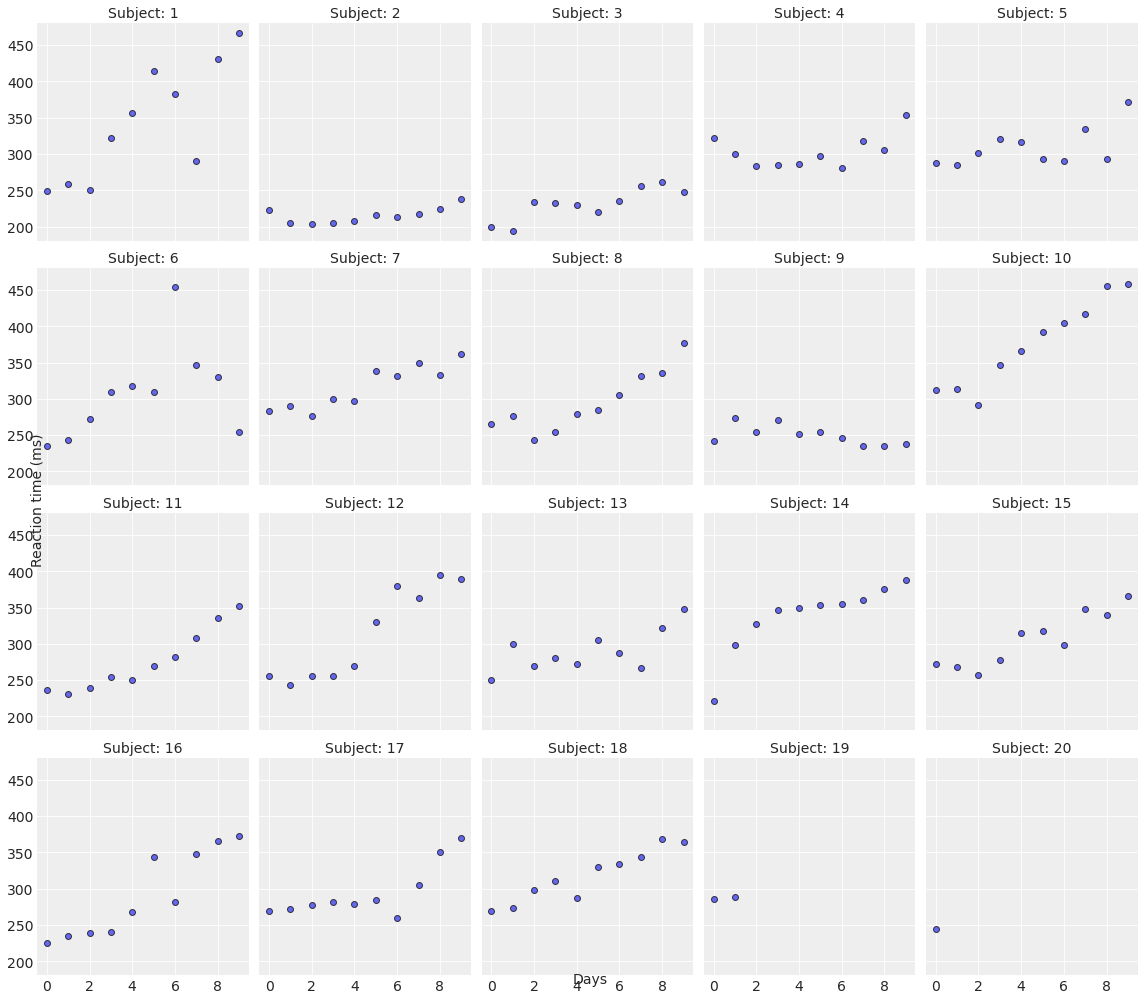

In [5]:
plot_data(data)
plt.show()

## Model 1: "Pooled" Model

analogous to a fixed-effects model

Formula: Reaction ~ 1 + Days
Family name: Gaussian
Link: identity
Observations: 183
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.0897, sigma: 255.1709)
    Days ~ Normal(mu: 0.0, sigma: 48.1899)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 55.8615)

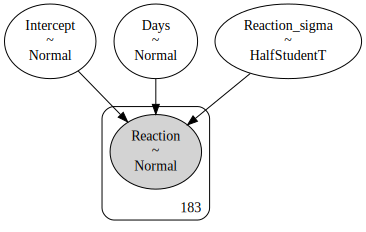

In [6]:
model = bmb.Model("Reaction ~ 1 + Days", data)
display(model)
model.build()
model.graph()

### Before sampling: the prior predictive check

* Compare the generative model's predictions to your observed data

/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


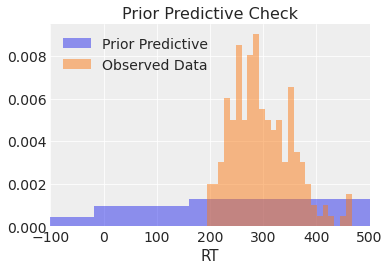

In [7]:
prior_predictive_RTs = model.prior_predictive().prior_predictive.Reaction.values.flatten()
plt.hist(prior_predictive_RTs, alpha=0.5, bins=25, density=True, label="Prior Predictive")
plt.hist(data.Reaction.values, alpha=0.5, bins=25, density=True, label="Observed Data")
plt.xlim([-100, 500])
plt.title("Prior Predictive Check")
plt.xlabel("RT")
plt.legend()
plt.show()
hide_code_slideshow()

## Sampling

In [19]:
trace = model.fit(draws=1000, chains=4, random_seed=SEED)
model.predict(trace, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Days|Subject_offset, Days|Subject_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


### Sampler Diagnostics

In [9]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.083,0.059,5780.0,2982.0,1.0
Days,0.017,0.012,5087.0,3134.0,1.0
Reaction_sigma,0.036,0.026,5184.0,3219.0,1.0


> One can interpret R-hat with diverse seeding as an operationalization of the qualitative statement that, after warmup, convergence of the Markov chain should be relatively insensitive to the starting point, at least within a reasonable part of the parameter space. This is the closest we can come to verifying empirically that the Markov chain is geometrically ergodic, which is a critical property if we want a central limit theorem to hold for approximate posterior expectations.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2021). Rank-normalization, folding, and localization: An improved ̂R for assessing convergence of MCMC (with Discussion). Bayesian analysis, 16(2), 667-718.

### Trace Plots

Each line type represents a different chain of our sampling process. (Recall that four independent chains were run.)

Left: smoothed histogram. Right: trace plot (the state of the chain at each iteration $t$).

/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


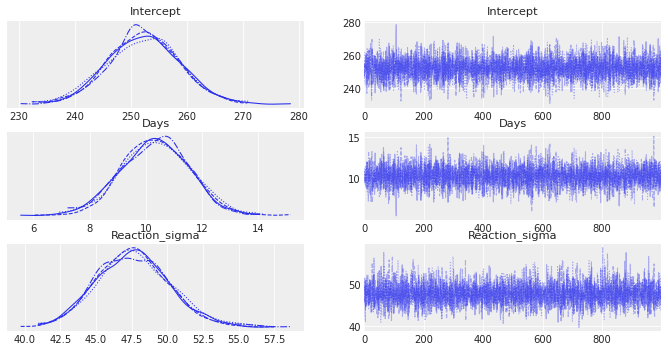

In [10]:
az.plot_trace(trace)
plt.show()

### Posterior Predictive Check

* In the same spirit of the prior predictive check, but now with our posterior estimates!

<AxesSubplot:xlabel='Reaction / Reaction'>

/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


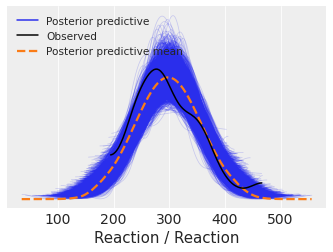

In [11]:
az.plot_ppc(trace)

## Model 2: "Partial Pooling" Model

analogous to a mixed-effects model

Formula: Reaction ~ 1 + Days + (Days | Subject)
Family name: Gaussian
Link: identity
Observations: 183
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.0897, sigma: 255.1709)
    Days ~ Normal(mu: 0.0, sigma: 48.1899)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 255.1709))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.1899))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 55.8615)

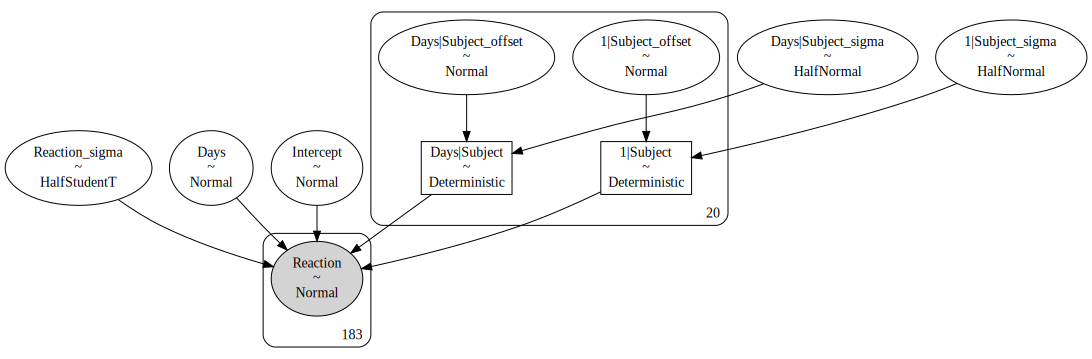

In [13]:
model = bmb.Model("Reaction ~ 1 + Days + (Days | Subject)", data)
display(model)
model.build()
model.graph()

### The prior predictive...

/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


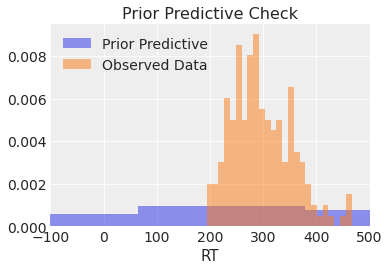

In [14]:
prior_predictive_RTs = model.prior_predictive().prior_predictive.Reaction.values.flatten()
plt.hist(prior_predictive_RTs, alpha=0.5, bins=25, density=True, label="Prior Predictive")
plt.hist(data.Reaction.values, alpha=0.5, bins=25, density=True, label="Observed Data")
plt.xlim([-100, 500])
plt.title("Prior Predictive Check")
plt.xlabel("RT")
plt.legend()
hide_code_slideshow()

### Running MCMC

In [15]:
trace = model.fit(draws=1000, chains=4, random_seed=SEED)
model.predict(trace, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Days|Subject_offset, Days|Subject_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


### Base Diagnostics

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,252.332,7.012,239.644,265.688,0.154,0.109,2114.0,2235.0,1.0
Days,10.369,1.702,7.017,13.392,0.050,0.036,1157.0,1459.0,1.0
1|Subject_sigma,26.101,6.139,15.380,37.697,0.146,0.104,1724.0,2309.0,1.0
1|Subject[1],0.589,13.841,-27.014,25.030,0.239,0.215,3371.0,2633.0,1.0
1|Subject[2],-40.608,14.366,-66.874,-13.550,0.231,0.165,3886.0,3113.0,1.0
1|Subject[3],-39.234,14.508,-67.895,-12.847,0.247,0.176,3421.0,2887.0,1.0
1|Subject[4],24.099,13.869,-1.164,50.039,0.252,0.191,3070.0,2736.0,1.0
1|Subject[5],22.256,13.805,-3.900,46.948,0.250,0.194,3084.0,2881.0,1.0
1|Subject[6],8.653,13.638,-15.583,35.334,0.242,0.191,3194.0,2999.0,1.0
1|Subject[7],16.388,13.483,-8.224,42.090,0.237,0.188,3284.0,3066.0,1.0


/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


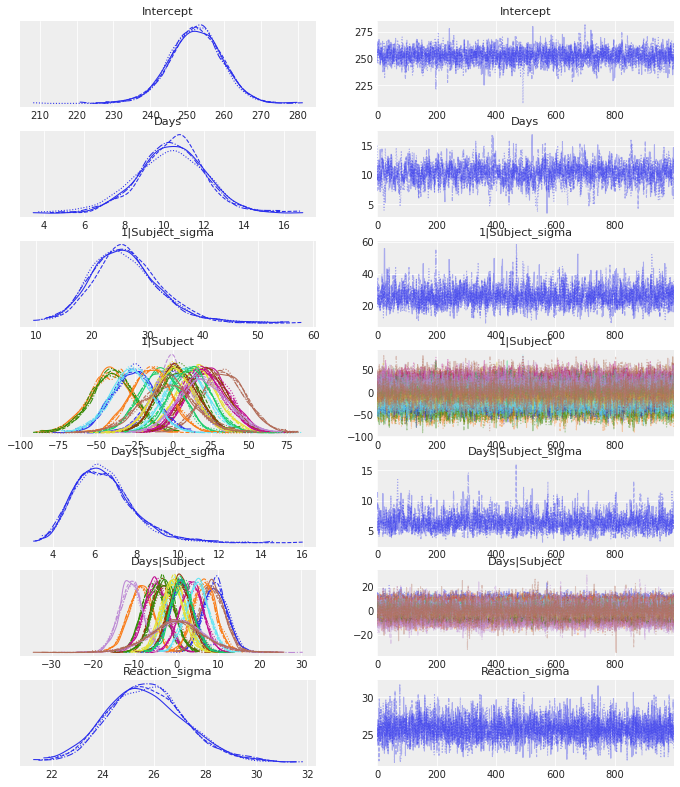

In [17]:
az.plot_trace(trace)
plt.show()

### Posterior Predictive ...

<AxesSubplot:xlabel='Reaction / Reaction'>

/home/cove/Lab/mcmc-talk/venv-mcmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


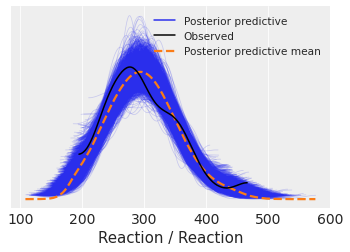

In [18]:
az.plot_ppc(trace)

* Any suggestions for modifying our model?

In [86]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 06 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy     : 1.21.6
arviz     : 0.12.0
bambi     : 0.7.1
pandas    : 1.4.2
IPython   : 8.3.0
scipy     : 1.7.3
seaborn   : 0.11.2
matplotlib: 3.5.2

Watermark: 2.3.0

